# Importations et lignes de commandes

##### Télécharge le fichier json et le range dans le bon dossier (Uniquement pour google collab)

In [269]:
!mkdir -p ../data && wget -O ../data/Subscription_Boxes.jsonl "https://nilsmt.github.io/NilsDoesStuff/assets/Subscription_Boxes.jsonl"

La syntaxe de la commande n'est pas correcte.


##### Télécharge les packages Python

In [270]:
%pip install spacy
%pip install unidecode
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----------------------------- ---------- 9.4/12.8 MB 53.3 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 44.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

##### création d'une colormap customisé

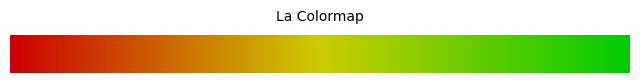

In [272]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0.8, 0, 0), (0.8, 0.8, 0), (0, 0.8, 0)]
cmap_name = "RedYellowGreen"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Visualisation de la cmap
gradient = np.linspace(0, 1, 256).reshape(1, -1)  # dégradé de 0 à 1
fig, ax = plt.subplots(figsize=(8, 0.5))  # Taille

ax.imshow(gradient, aspect="auto", cmap=custom_cmap)
ax.set_axis_off()
plt.title("La Colormap", fontsize=10, pad=10)
plt.show()

##### Choix random state

In [273]:
rdmstate = 96

# a. Choix du jeu de données
Après avoir constitué votre binôme, choisissez le jeu de données sur lequel vous
souhaitez travailler, indiquez-le dans le tableur dont le lien se trouve sur madoc puis
demandez la validation de votre jeu de données à votre enseignant.

In [297]:
df = pd.read_json("../data/Subscription_Boxes.jsonl", lines=True, encoding='utf-8')

# b. Pré-traitement du texte
En général, les données ne peuvent pas être utilisées directement. Il faudra mettre
en place des pré-traitements (suppression des éventuelles lignes en doublon, trai-
tement des cellules vides, . . .). Il faudra également séparer vos données en un en-
semble d’apprentissage, un ensemble de validation et un ensemble de test. 
Ces 3 sous-ensembles seront utilisés tout au long des expérimentations effectuées pour ré-
pondre aux questions suivantes. Vous pouvez également considérer, dans un premier
temps, un sous-ensemble de votre ensemble d’apprentissage, pour mettre au point
chacune de vos approches.

##### Affichage de la répartition du dataframe

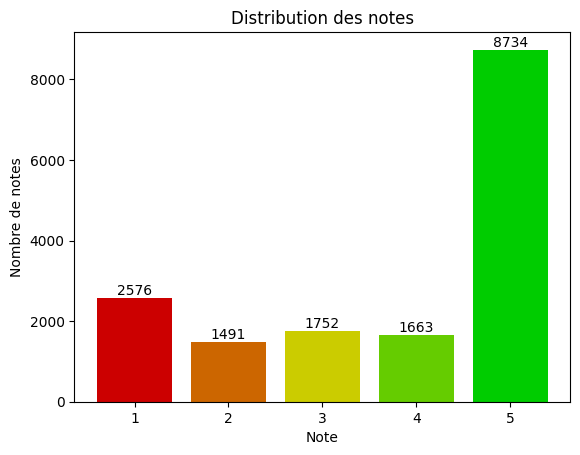

In [ ]:
import matplotlib.colors as mcolors

rating_counts = df.groupby("rating").size()
x = rating_counts.index
y = rating_counts.to_numpy()

# coloration des barres
norm = mcolors.Normalize(vmin=min(x), vmax=max(x))
colormap = custom_cmap
colors = colormap(norm(x))

# textes sur les barres
for i, value in zip(x, y):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom')

plt.bar(x, y, color=colors)

plt.title("Distribution des notes")
plt.xlabel("Note")
plt.ylabel("Nombre de notes")

plt.show()

Conclusion : la distribution des avis est inégale, il faut donc sélectionner le même nombre de chaque avis

##### Suppression des vides et duplications

In [276]:
# 1 - suppression des duplications (clé primaire : asin + user)

df = df.drop_duplicates(subset=["asin","user_id"], keep='last')
df = df.dropna()

##### Réduction du dataframe afin d'avoir de meilleures répartitions (500 avis de chaque notes)

In [277]:
df = df.groupby('rating').apply(lambda x: x.sample(n=500, random_state=rdmstate)).reset_index(drop=True)
print(df.shape)

(2500, 10)


C:\Users\Nils\AppData\Local\Temp\ipykernel_16568\645898023.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('rating').apply(lambda x: x.sample(n=500, random_state=rdmstate)).reset_index(drop=True)


In [278]:
import html
import unidecode

# traitement des données

# 2 - nettoyage du texte

def clean_text_col(row: pd.Series) -> pd.Series:
    # traduit les <br>
    html_el_regex = r'<br\s*/?>' # "<br" [un espacement, 0..*] [un "/", 0..1] ">"
    row = row.str.replace(html_el_regex, "\n", regex=True)
    # traduit les symboles html (comme &#34)
    row = row.apply(html.unescape)
    # traduit les symboles unicodes (comme \u00e9)
    row = row.apply(unidecode.unidecode)

    return row

df[["title","text"]] = df[["title","text"]].apply(clean_text_col)

# 3 - lemmatisation du texte

nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text: str) -> str :
    doc = nlp(text)

    lemma_list = []

    for token in doc:
        # on ne garde que les noms, les noms propres, les verbes, les adjectifs et la ponctuation
        if token.pos_ in ["NOUN","PROPN","VERB","ADJ","PUNCT"]:
            lemma_list.append(token.lemma_.lower())
    return "\u0020".join(lemma_list) # 0020 est le code unicode pour l'espace


for i,row in df.iterrows():
    lemma_text = lemmatize_text(row["text"])
    lemma_title = lemmatize_text(row["title"])

    row["text"] = lemma_text
    row["title"] = lemma_title

    df.loc[i] = row

df["title_text"] = df["title"] + df["text"]

# c. Clustering des avis
Vous utiliserez l’algorithme des k-moyennes pour trouver le nombre de clusters optimal pour partitionner vos données. 
Pour ce faire, vous devrez :
- réaliser plusieurs expérimentations, avec des pré-traitements différents sur le texte
des avis
- optimiser les hyperparamètres du modèle entraîné, pour chaque expérimentation.
Le but est de déterminer, à l’aide de plusieurs expérimentations différentes, la confi-
guration permettant d’obtenir les meilleurs résultats, sur votre ensemble de validation,
en utilisant les métriques vues en TD de Modélisations mathématiques. Vous appli-
querez enfin le modèle de clustering choisi, sur votre ensemble de test.

In [279]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#Supression des éléments nuls
df = df.dropna(axis=0)

# Séparation en trois jeux de données
carac = df[["title_text","helpful_vote","verified_purchase"]]
label = df["rating"]

# 60% train, 20% validate, 20% test
x, x_test, y, y_test = train_test_split(carac,label,test_size=0.2)
x_train, x_validate, y_train, y_validate = train_test_split(x,y,test_size = 0.25)

#def VectorizeByRow(x, analyz: str):
#  vect = x["title_text"].copy()
#  mod = CountVectorizer(analyzer=analyz).fit(x["title_text"])
#  for index, row in x.iterrows():
#    if(row["title_text"]==""):
#      row["title_text"]="ok"
#    txt = row["title_text"].split()
#    vect.loc[index] = mod.transform(txt).toarray()
#  print(vect)
#  return vect

def Vectorize(x):
  row=x["title_text"]
  mod = CountVectorizer(analyzer='word', max_features = 100).fit(row)
  vect = mod.transform(row)
  return vect

vect_train  = Vectorize(x_train,)

vect_test = Vectorize(x_test)

vect_validate =  Vectorize(x_validate)

print(vect_train.shape)
print(vect_test.shape)
print(vect_validate.shape)

(1500, 100)
(500, 100)
(500, 100)


##### Représentation graphique du texte des avis

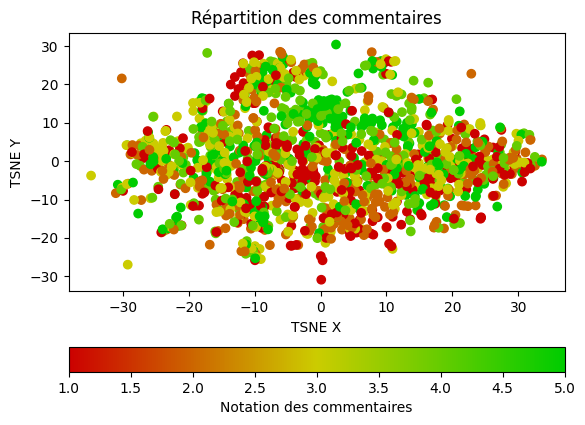

In [280]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)  # Reduit en 2 dimensions
reduced_data = tsne.fit_transform(vect_train.toarray())

# graphique
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], cmap=custom_cmap, c=y_train)
plt.xlabel('TSNE X')
plt.ylabel('TSNE Y')
plt.title('Répartition des commentaires')
plt.colorbar(label="Notation des commentaires", orientation="horizontal") 
plt.show()

Conclusion : on remarque qu'on ne peux pas classer les avis avec uniquement le TNSE, il faut une autre approche pour la classification

##### Répartition avec "helpful_vote"
à des fins purement statistiques

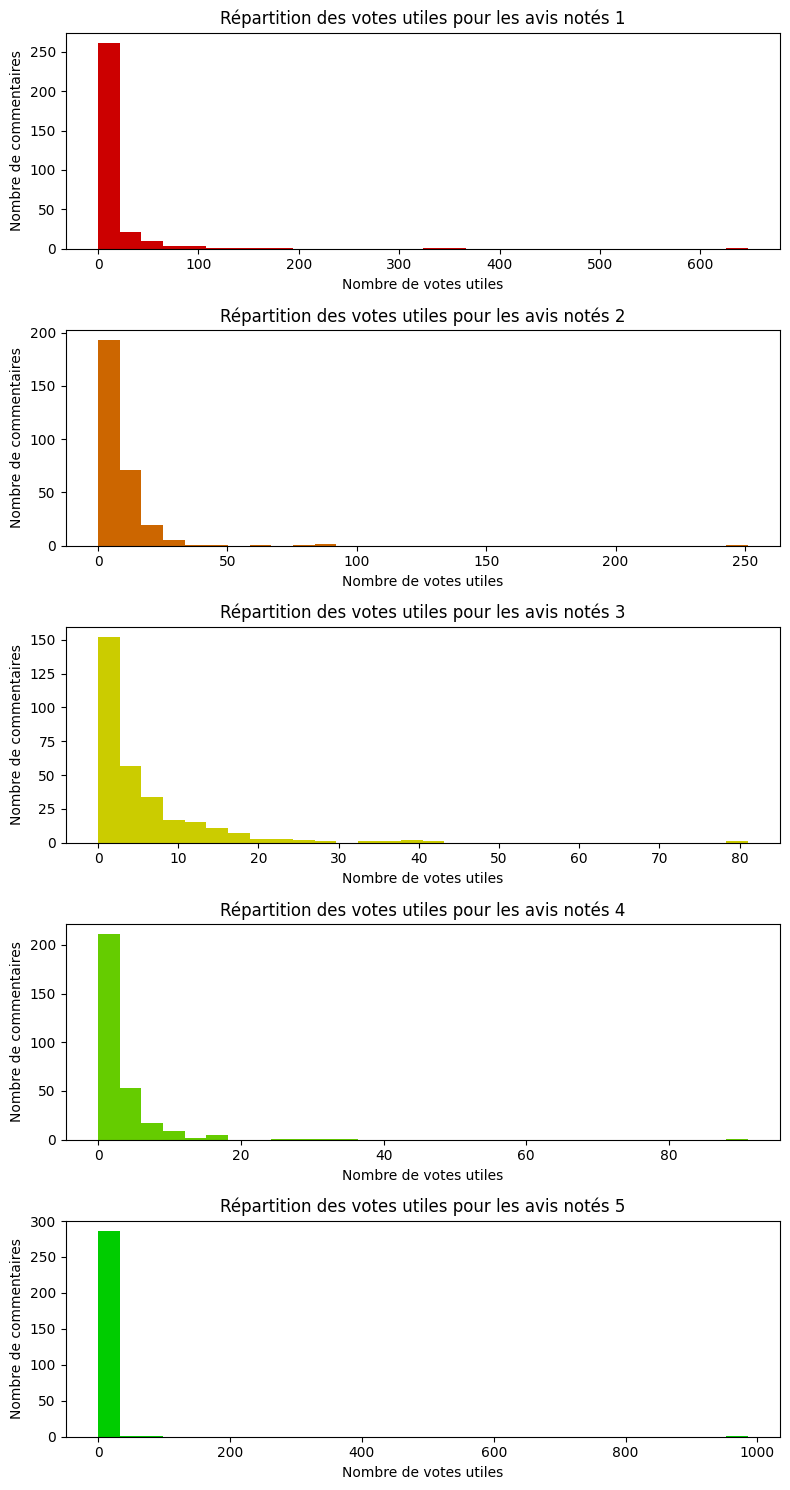

In [298]:
fig, axes = plt.subplots(5, 1, figsize=(8, 15))

for i, ax in enumerate(axes, start=1):
    ax.hist(
        x_train.loc[y_train == i, "helpful_vote"],
        bins=30, color=colors[i-1], orientation="vertical"
    )
    
    ax.set_xlabel("Nombre de votes utiles")
    ax.set_ylabel("Nombre de commentaires")
    ax.set_title(f"Répartition des votes utiles pour les avis notés {i}")

plt.tight_layout()
plt.show()

##### Répartition avec "verified purchase"
à des fins purement statistiques

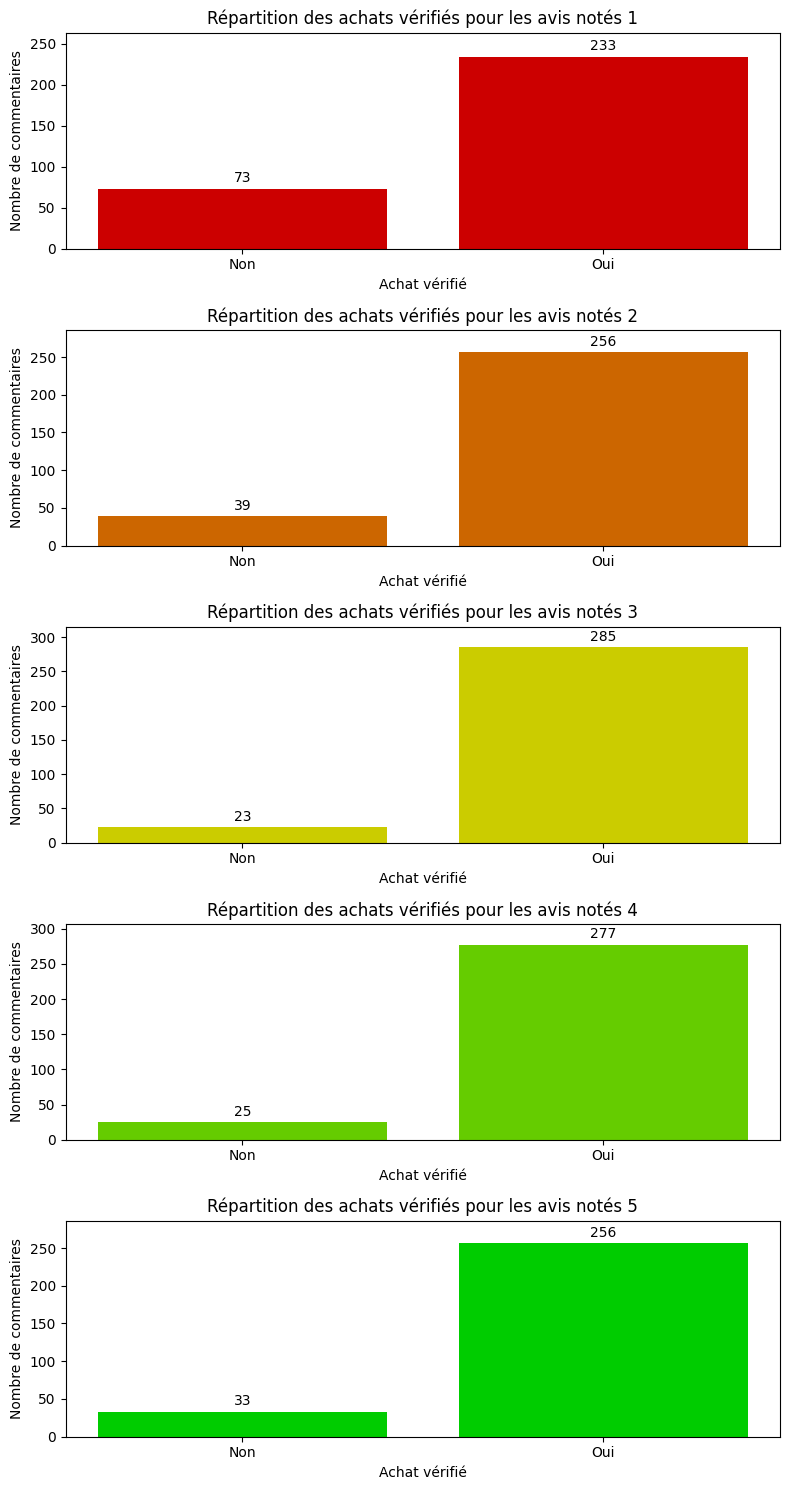

In [282]:
fig, axes = plt.subplots(5, 1, figsize=(8, 15))

for i, ax in enumerate(axes, start=1):

    # compte le nombre d'achats vérifiés pour chaque note
    counts = x_train.loc[y_train == i, "verified_purchase"].value_counts()
    
    ax.bar(counts.index, counts, color=colors[i-1])

    bins = [1, 0]

    ax.set_xticks(bins)
    ax.set_xticklabels(['Oui', 'Non'])

    ax.set_xlabel("Achat vérifié")
    ax.set_ylabel("Nombre de commentaires")
    ax.set_title(f"Répartition des achats vérifiés pour les avis notés {i}")
    
    for j, count in enumerate(counts):
        ax.text(bins[j], count + 5, str(int(count)), ha='center', va='bottom')

    # padding intérieur pour pas que les nombres (ax.text) soient collés aux barres
    ax.set_ylim(0, max(counts) + 30)

plt.tight_layout()
plt.show()

#### Sélection du nombre optimal de cluster avec la méthode du coude

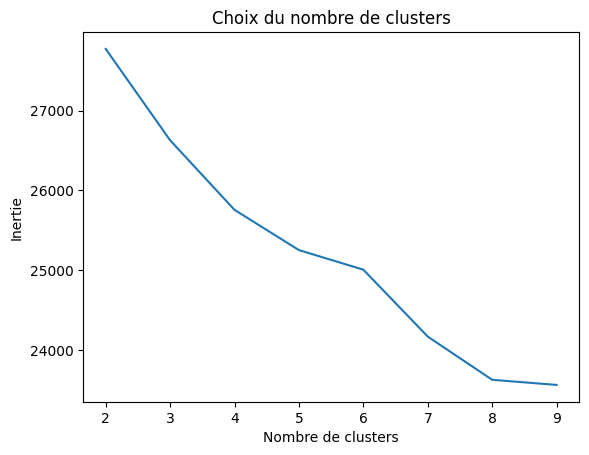

In [283]:
from sklearn.cluster import KMeans
range_cl = range(2, 10)
scores = []

for k in range_cl:
  model = KMeans(n_clusters=k, random_state=rdmstate)
  model.fit(vect_train)
  scores.append(model.inertia_)

plt.plot(range_cl, scores)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Choix du nombre de clusters")

plt.show()

Conclusion : Le nombre de clusters optimal semble être 3 ou 4.

#### Sélection du nombre optimal de cluster avec le score de silhouette

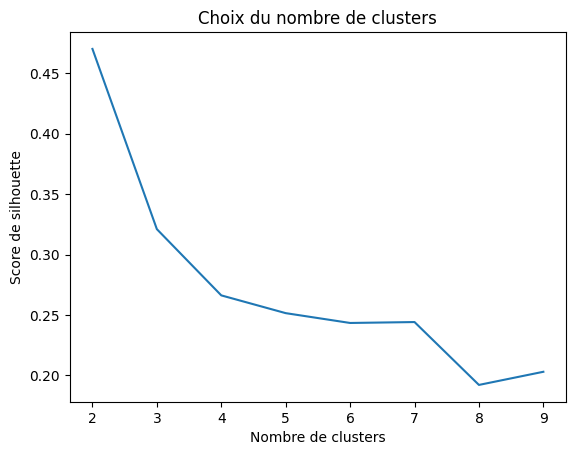

In [284]:
from sklearn.metrics import silhouette_score

range_cl = range(2, 10)
scores = []
for k in range_cl:
    model = KMeans(n_clusters = k, random_state=rdmstate, n_init='auto')
    model.fit(vect_train)
    scores.append(silhouette_score(vect_train,model.labels_, metric='euclidean'))

plt.plot(range_cl, scores)
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.title("Choix du nombre de clusters")

plt.show()

Conclusion : le meilleur score est atteint avec 2 clusters, le moins bon est avec 7

##### Sélection des meilleurs hyperparamètres

In [285]:
from sklearn.model_selection import GridSearchCV

parametre_grid = {"n_clusters": [2, 3, 4, 5],
      "max_iter": range(300,350),
      "algorithm": ["lloyd", "elkan"]}
grid_search = GridSearchCV(KMeans(random_state=rdmstate), param_grid=parametre_grid, scoring='accuracy')
grid_search.fit(vect_train, y_train)

print(grid_search.best_params_)

{'algorithm': 'lloyd', 'max_iter': 300, 'n_clusters': 5}


##### Utilisation des meilleurs paramètres

In [286]:
kmean = KMeans(
    n_clusters=grid_search.best_params_["n_clusters"], 
    max_iter=grid_search.best_params_["max_iter"], 
    algorithm=grid_search.best_params_["algorithm"],
)

kmean.fit(vect_validate)
print(kmean.predict(vect_test))

[1 1 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 4 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 4 1 1 1 1 1 1 4 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 4 1 1 1
 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 4 1 1 1 4 1 1 1 1 1 4
 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 1 1 1 1
 1 1 1 1 1 1 1 1 1 4 1 1 1 4 1 4 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 4 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 4 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 4 1 1 1 1 1 4 1 1 1 1 1 1 1 1
 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 4 1 1 1 1 1 1 1 1 4
 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 4 1
 1 1 4 1 1 1 1 4 4 1 4 1 1 1 1 1 1 4 1 1 1 1 1 4 1 1 1 4 1 1 1 1 1 4 1 1 1
 1 1 4 1 1 1 1 1 1 1 1 1 

# d. Classification binaire des avis (deux classes à prédire)
Il y aura deux classes à prédire : elles correspondront à avis favorable et avis défavorable. 
Vous utiliserez un des algorithmes de classification qui a été vu en TD de
Modélisations mathématiques. 
Vous devrez :
- réaliser plusieurs expérimentations, avec des pré-traitements différents sur le texte
des avis
- optimiser les hyperparamètres du classifieur, pour chaque expérimentation.
Le but est également de déterminer, à l’aide de plusieurs expérimentations diffé-
rentes, la configuration permettant d’obtenir les meilleurs résultats, sur votre ensemble
de validation, puis de calculer les résultats obtenus sur votre ensemble de test. Faites
attention à la prise en compte du déséquilibre que vous pourrez avoir entre vos deux
classes, en termes de nombre d’avis dans chacune des classes

##### Binarisation des notes utilisateurs

In [287]:
y_binary_train=pd.Series()
y_binary_validate=pd.Series()
y_binary_test=pd.Series()

for i, v in y_train.items():
  if(v>3):
    y_binary_train.loc[i]=1
  else:
    y_binary_train.loc[i]=0

for i, v in y_validate.items():
  if(v>3):
    y_binary_validate.loc[i]=1
  else:
    y_binary_validate.loc[i]=0

for i, v in y_test.items():
  if(v>3):
    y_binary_test.loc[i]=1
  else:
    y_binary_test.loc[i]=0

##### Sélection des meilleurs hyperparamètres

In [288]:
from sklearn.neighbors import KNeighborsClassifier
parametre_grid = {"n_neighbors" : [5,7,9,11,13,15],
               "weights" : ['uniform','distance'],
               "metric" : ['minkowski','euclidean','manhattan']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=parametre_grid, scoring='accuracy')
grid_search.fit(vect_train, y_binary_train)

print(grid_search.best_params_)

{'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'distance'}


##### Utilisation des meilleurs paramètres

In [289]:
neigh = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"], weights=grid_search.best_params_["weights"], metric=grid_search.best_params_["metric"])
neigh.fit(vect_validate, y_binary_validate)
predict_binary = neigh.predict(vect_test)
print(predict_binary)
print(y_binary_test)

[0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1
 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0
 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0
 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0
 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1
 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1
 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0
 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0
 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1
 1 1 0 1 1 0 0 1 0 1 1 1 

##### Accuracy

In [290]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_binary_test, predict_binary)
print(accuracy)

0.554


# e. Classification multiclasse des avis (plus de deux classes à prédire)
Le but est de réaliser les mêmes expérimentations qu’à la question précédente mais
en utilisant uniquement les pré-traitements du texte ayant permis d’obtenir les meilleurs
résultats lors de la classication binaire. Vous devrez maintenant prédire plus de deux
classes possibles. Vous pouvez reprendre le nombre de clusters optimal, que vous
avez trouvé précédemment, pour fixer le nombre de classes considérées ici. Vous
indiquerez les notes auxquelles correspondent chacune de vos classes.

In [291]:
#5 clusters, donc une note différente par cluster
neigh.fit(vect_validate, y_validate)
predict = neigh.predict(vect_test)
print(predict)
print(y_test)

[3 2 5 1 4 5 3 1 1 3 2 5 5 1 1 5 5 2 4 1 5 5 1 5 5 5 5 5 4 5 5 4 2 2 1 1 5
 4 1 4 5 4 5 1 3 5 3 5 5 5 5 4 2 2 5 2 5 4 5 4 2 5 5 5 2 1 5 5 5 4 2 5 3 1
 5 2 5 2 5 5 5 1 4 5 2 1 5 4 5 2 5 2 4 5 4 5 5 4 2 5 5 1 4 3 5 3 5 1 5 2 1
 2 3 2 2 5 5 5 2 2 5 5 5 2 3 5 5 5 1 5 5 5 1 5 5 4 5 4 5 5 4 3 3 5 4 2 2 3
 5 5 5 2 3 2 1 5 2 5 5 5 5 3 2 5 5 5 5 5 5 2 4 5 1 2 5 5 5 2 4 5 1 5 5 5 2
 4 5 4 2 5 1 4 1 5 2 5 2 5 3 5 4 2 3 5 1 4 2 5 5 5 4 5 5 3 1 2 4 2 2 5 5 5
 5 5 4 5 5 1 2 4 5 1 5 4 2 5 1 5 2 2 5 1 2 4 5 2 5 1 1 4 2 2 3 5 5 5 1 4 4
 5 5 5 5 2 2 1 2 4 5 2 3 2 5 2 5 2 5 1 5 1 2 5 2 1 5 5 5 5 2 4 2 5 1 5 5 1
 2 5 5 2 5 5 5 5 5 5 5 5 3 1 1 5 5 3 1 5 5 5 5 5 5 2 5 1 2 4 3 3 5 5 1 5 5
 5 5 4 5 5 1 5 3 1 5 1 5 5 3 2 1 5 5 4 5 5 5 4 1 1 3 5 4 1 2 5 2 2 5 5 4 5
 5 2 2 2 2 2 1 5 5 5 2 5 1 3 2 5 5 4 2 3 5 4 2 5 1 5 5 5 2 5 5 3 4 3 2 5 2
 5 5 4 1 5 2 3 5 5 5 5 2 5 2 5 2 5 5 1 5 5 2 1 2 1 2 5 3 4 5 4 5 2 5 5 1 3
 2 5 3 5 1 1 5 1 4 5 2 3 1 5 5 5 2 3 2 3 5 5 5 3 4 3 5 4 5 2 5 1 5 1 5 5 5
 5 5 1 5 5 1 5 5 1 5 5 5 

In [292]:
accuracy = accuracy_score(y_test, predict)
print(accuracy)

0.26


# f. Régression pour la prédiction des notes des avis
Le but est maintenant de prédire les notes des avis, en utilisant la régression linéaire.<br>
Dans un premier temps, vous utiliserez uniquement les avis textuels pour effectuer
votre régression linéaire, sur votre ensemble d’apprentissage.<br>
Dans un second temps,
vous pourrez essayer d’ajouter les autres informations disponibles sur les avis, pour
voir si ces informations peuvent améliorer les résultats de la régression.

#### Le premier temps
Régression linéaire avec title_text uniquement

In [293]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

regression_model = LinearRegression()
regression_model.fit(vect_train, y_train)

reg_predict = regression_model.predict(vect_test)

mse = mean_squared_error(y_test, reg_predict)
rmse = root_mean_squared_error(y_test, reg_predict)
r2 = r2_score(y_test, reg_predict)

# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Mse : ", mse)
print("Rmse : ", rmse)
print('Score R2 : ', r2)

Pente :  [ 0.07217514 -0.08042984 -0.17322514 -0.00247436 -0.17230587 -0.02357306
 -0.14285272 -0.48983138  0.06737998 -0.17092867 -0.02456873 -0.22862281
  0.10828105 -0.16513614 -0.05918786  0.05091133 -0.07160828  0.30447037
 -0.36736209 -0.19504749  0.05090909 -0.02235569  0.08016004  0.03899771
  0.37377343 -0.05947669  0.30517321 -0.22224156 -0.11316265  0.27866425
  0.36254177  0.03078222 -0.32127354 -0.1165124   0.14382294  0.01689804
  0.14536358 -0.11013578 -0.24320316 -0.27144354  0.2143607   0.04064917
  0.00673814  0.07757538  0.63488414  0.03363763 -0.1547018  -0.40304128
 -0.03045239 -0.00394755 -0.12661967  0.11710181  0.35329351  0.32825602
  0.56622884  0.04172394  0.01358063 -0.12050417  0.16903354  0.11745001
 -0.06677958  0.10221953 -0.00660528 -0.13580257  0.05808947  0.15734712
  0.0502524  -0.16610113  0.2239279  -0.10090028 -0.12892442 -0.13827725
  0.02871153  0.11908825 -0.15032685 -0.13139783 -0.058609   -0.05063513
 -0.0464309  -0.03357777 -0.09034811 -0.10

#### Création des ndarray contenant title_text, helpful_vote et verified_purchase

In [294]:
x_train_vect = np.ndarray(shape=(vect_train.shape[0],102), dtype=float)
x_test_vect = np.ndarray(shape=(vect_test.shape[0],102), dtype=float)
x_validate_vect = np.ndarray(shape=(vect_validate.shape[0],102), dtype=float)
count = 0
for index, row in x_train.iterrows():
  x_train_vect[count] = np.append(vect_train.toarray()[count],x_train.loc[index,"helpful_vote":"verified_purchase"])
  count+=1

count = 0
for index, row in x_test.iterrows():
  x_test_vect[count] = np.append(vect_test.toarray()[count],x_test.loc[index,"helpful_vote":"verified_purchase"])
  count+=1

count = 0
for index, row in x_validate.iterrows():
  x_validate_vect[count] = np.append(vect_validate.toarray()[count],x_validate.loc[index,"helpful_vote":"verified_purchase"])
  count+=1


##### Le second temps
Régression linéaire avec title_text, helpful_vote et verified_purchase

In [295]:
#Régression linéaire
regression_model.fit(x_train_vect, y_train)

reg_predict = regression_model.predict(x_test_vect)

mse = mean_squared_error(y_test, reg_predict)
rmse = root_mean_squared_error(y_test, reg_predict)
r2 = r2_score(y_test, reg_predict)

# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Mse : ", mse)
print("Rmse : ", rmse)
print('Score R2 : ', r2)

Pente :  [ 0.0866038  -0.05950215 -0.15683156 -0.01359039 -0.15339898 -0.00850867
 -0.11459247 -0.48138622  0.06734726 -0.10535218 -0.01108983 -0.19200106
  0.09267842 -0.12967716 -0.05653987  0.04659572 -0.08331513  0.26312916
 -0.35976492 -0.18600987  0.03813311 -0.06026346  0.03603632  0.01174683
  0.41915206 -0.04249737  0.34529768 -0.22931839 -0.12566021  0.24254592
  0.33746553  0.01847372 -0.29531822 -0.11507674  0.14680221  0.02025056
  0.17521037  0.09783082 -0.19716818 -0.24480123  0.19947729  0.04592024
  0.01423627  0.11654254  0.63754312  0.03554565 -0.11264276 -0.37204271
 -0.00901404 -0.01246801 -0.13590353  0.08108617  0.32333343  0.31173673
  0.54580047  0.05499106  0.02125454 -0.11240196  0.18350318  0.09624888
 -0.03843836  0.11015001 -0.00094592 -0.14303623  0.06395271  0.1723595
  0.05235479 -0.16436846  0.22121048 -0.1617741  -0.10132598 -0.14932764
  0.07409948  0.08847212 -0.15611968 -0.02829763 -0.05092797 -0.04964677
 -0.05221724 -0.01612549 -0.08215882 -0.131

Conclusion : les résultats s'améliores mais de peu

# g. Bonus (pour aller plus loin)
Vous pouvez utiliser d’autre méthodes de clustering ou de classification, en plus de
celles vues en cours, mais elles doivent pouvoir être exécutées sur les ordinateurs
de l’IUT. En revanche, vous devrez avoir compris le fonctionnement de ces nouvelles
méthodes et être capable d’en expliquer le principe (dans le rapport et lors de la
soutenance).

In [296]:
# TODO